# 3806ICT Assignment
Ken Quach - Yunpeng Huang - Kai Sato - Wui Theam Wong

In [1]:
import random
import math
import numpy as np
import sys
import time

import collections
import matplotlib.pyplot as plt

# Reinforcement Learning

## Grid World

In [2]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    # skip the last two line (those are coordinate of start)
    def read_map(self, fn):
        grid = []
        f = open(fn,"r")
        lines = f.readlines()
        for line in lines[:-2]:
            grid.append(list(line.strip()))
        f.close()
        return np.asarray(grid)

    # Print the map
    def print_map(self):
        gridx = len(self._map) 
        gridy = len(self._map[0]) 
        
        for i in range(0, gridy):
            for j in range(0, gridx):
                if (self._map[i][j] == 'u'):
                    print(str(self._map[i][j]), end="   ")
                elif (self._map[i][j] == 'c'):
                    print(str(self._map[i][j]), end="   ")
                else:
                    print(str(self._map[i][j]), end="   ")
            print('\n')
        
    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [3]:
env = GridWorld("grid.txt")
if len(env._map) < 30 and len(env._map[0]) < 30:
    env.print_map()
len(env._map)

50

In [4]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

## RL Agent

In [5]:
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
        
    def greedy(self, s):
        return np.argmax(self.Q[s[0], s[1]])

    def epsilon_greed(self, e,s):
        if np.random.rand() < e:
            return np.random.randint(self.n_a)
        else:
            return self.greedy(s)
    
    def train(self, start, **params):
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
        # init self.Q matrix
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for j in range(maxiter):

            self.env.init(start)
            s = self.env.get_cur_state()
            # selection an action
            a = self.epsilon_greed(epsilon, s)

            rewards = []
            trace = np.array(coord_convert(s, self.size))
            # run simulation for max number of steps 
            for step in range(maxstep):
                # move
                r = self.env.next(a)
                s1 = self.env.get_cur_state()
                a1 = self.epsilon_greed(epsilon, s1)

                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))
            
                # update self.Q table 
                self.Q[s[0],s[1],a] += alpha*(r + gamma * np.max(self.Q[s1[0],s1[1],:]) - self.Q[s[0],s[1],a])
                
                if self.env.is_goal(): # reached the goal
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1
                a = a1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=1000):
        env.init(start)
        s = env.get_cur_state()
        a = np.argmax(self.Q[s[0], s[1], :])
        trace = np.array(coord_convert(s, self.size))
        for step in range(maxstep):
            env.next(a)
            s1 = env.get_cur_state()
            a1 = np.argmax(self.Q[s1[0], s1[1],:])
            trace = np.vstack((trace, coord_convert(s1, self.size)))
            if env.is_goal():  # reached the goal
                break
            a = a1
        
        return trace

# Results

### Show the direction of RL agents

In [6]:
# Determine the direction of the RL agent.
def direction(tracecurrent, tracenext):
    if tracenext[0] < tracecurrent[0]:
        print("go_left", end='')
    elif tracenext[0] > tracecurrent[0]:
        print("go_right", end='')
    elif tracenext[1] > tracecurrent[1]:
        print("go_up", end='')
    elif tracenext[1] < tracecurrent[1]:
        print("go_down", end='')
    elif tracenext[0] == tracecurrent[0] and tracenext[1] == tracecurrent[1]:
        print("idle", end='')



### Plotting tools

In [7]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    # Print left, right, up, and down based on the next position
    print("Route Taken: ", end='')
    for step in range(len(trace)-1):
        previouspos = trace[step]
        currentpos = trace[step+1] 
        direction(previouspos, currentpos)
        if step != (len(trace)-2):
            print("-> ", end='')
    print("\nSteps taken:",len(trace) - 1)    


def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    plt.plot(rtrace)
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    plt.plot(steps)
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

### Training and Testing with GridWorld

Get the coordinate of the start from text file

In [8]:
# get the coordinate of start from txt file
f = open('grid.txt',"r")
lines = f.readlines()
f.close()
start = list([int(lines[-2].strip()), int(lines[-1].strip())])
print("Start coord:",start)

Start coord: [28, 41]


In [9]:
# start timer for training
starttime = time.time()

agent = RLAgent(env)
start = [start[0],start[1]]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=40000)

test_trace = agent.test(start)

# end timer for training
endtime = time.time() - starttime
print("Total computation time (training + testing): ", endtime)


/Users/lunary/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


Total computation time (training + testing):  51.49734020233154


### Visualisation of the result for training and testing

Time taken: 51.49734020233154 seconds
GRID SIZE:  X:  50 Y:  50


Route Taken: go_right-> go_right-> go_right-> go_down-> go_down-> go_down-> go_down-> go_up-> go_up-> go_up-> go_up-> idle-> go_left-> go_left-> go_left-> go_left-> go_up-> idle-> go_down-> go_right-> go_right-> go_right-> go_right-> go_down-> go_down-> go_down-> go_down-> go_down-> go_down-> go_up-> go_up-> go_up-> go_up-> go_up-> idle-> idle-> go_up-> go_left-> go_left-> go_left-> go_left-> go_up-> go_down-> go_up-> go_up-> go_down-> go_down-> go_up-> go_up-> go_left-> go_left-> go_left-> go_right-> go_right-> idle-> go_right-> go_left-> go_left-> go_left-> go_left-> go_down-> go_up-> go_right-> go_right-> go_right-> go_right-> go_down-> go_up-> go_left-> idle-> idle-> go_left-> go_left-> go_left-> go_down-> go_down-> go_up-> go_down-> go_down-> go_up-> go_down-> go_down-> go_down-> go_up-> go_up-> idle-> go_down-> idle-> go_down-> go_down-> go_right-> go_left-> go_up-> go_up-> go_up-> go_up-> go_up-> go_down-> idle-> go_down-> go_down-> go_down-> go_down-> go_right-> go_right-> go_l

go_up-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> go_up-> idle-> go_up-> go_left-> go_left-> go_up-> go_up-> go_right-> go_right-> go_up-> go_up-> go_up-> go_up-> go_left-> go_left-> go_left-> go_left-> idle-> go_down-> go_down-> go_down-> go_down-> go_left-> go_left-> go_up-> idle-> go_up-> go_left-> go_left-> go_up-> go_up-> go_down-> go_down-> go_right-> go_right-> idle-> idle-> go_down-> go_down-> go_right-> go_right-> go_left-> go_left-> go_up-> go_up-> go_left-> idle-> go_left-> go_right-> go_right-> idle-> go_down-> go_down-> go_right-> go_right-> go_up-> go_up-> go_up-> go_up-> go_right-> go_right-> go_right-> go_right-> go_down-> idle-> go_down-> go_down-> go_down-> go_left-> go_left-> go_up-> go_up-> go_down-> go_down-> go_down-> go_down-> go_right-> go_right-> go_down-> go_down-> go_left-> go_left-> go_left-> go_left-> go_left-> go_left-> go_down-> go_down-> go_left-> go_left-> go_up-> idle-> go_up-> go_up-> go_up-> go_left-> go_left-> go_left-> idle-

go_left-> go_up-> go_up-> go_left-> go_left-> go_down-> go_down-> go_left-> go_left-> go_up-> go_up-> go_left-> go_left-> go_up-> go_up-> go_up-> go_up-> go_down-> go_down-> go_right-> go_right-> go_right-> go_right-> go_right-> go_left-> go_left-> go_left-> go_left-> go_left-> go_up-> go_up-> go_right-> go_left-> go_right-> go_right-> go_up-> go_up-> go_left-> go_left-> idle-> idle-> go_up-> go_up-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> go_up-> go_up-> go_up-> go_up-> go_down-> go_down-> go_down-> go_down-> idle-> go_down-> go_down-> go_down-> go_down-> go_up-> go_up-> go_up-> go_up-> go_left-> go_left-> go_left-> go_left-> go_left-> go_left-> go_left-> idle-> go_left-> go_down-> go_down-> go_right-> go_right-> go_down-> go_down-> go_left-> go_left-> go_down-> go_down-> go_up-> go_up-> go_right-> go_right-> go_up-> go_up-> go_left-> go_left-> go_up-> go_up-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> g

go_left-> go_left-> go_left-> go_up-> go_up-> go_left-> go_left-> go_up-> go_up-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> go_left-> go_left-> go_left-> go_left-> idle-> idle-> go_left-> go_left-> go_left-> go_down-> go_down-> go_right-> go_right-> go_down-> go_down-> go_right-> go_right-> go_right-> go_right-> go_up-> go_up-> go_left-> go_left-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> go_right-> go_down-> go_down-> go_down-> go_down-> go_left-> go_left-> go_up-> go_up-> go_left-> go_left-> go_down-> idle-> idle-> go_up-> go_down-> go_down-> go_down-> go_down-> go_left-> go_left-> go_down-> go_down-> go_up-> idle-> go_up-> go_right-> go_right-> go_up-> go_up-> go_up-> go_up-> go_right-> go_right-> go_down-> go_down-> go_right-> go_right-> go_up-> go_up-> go_up-> go_up-> idle-> go_left-> go_left-> go_left-> go_left-> idle-> go_left-> go_left-> go_left-> go_left-> go_down-> go_down-> go_up-> go

-> go_right-> go_left-> go_left-> go_up-> go_down-> go_up-> go_up-> go_right-> go_left-> go_down-> go_down-> go_right-> go_left-> go_up-> go_up-> go_right-> idle-> go_left-> idle-> idle-> go_down-> go_down-> go_right-> go_right-> go_left-> go_left-> go_up-> go_up-> go_right-> go_right-> idle-> idle-> go_left-> go_right-> go_up-> go_up-> go_up-> go_down-> go_up-> go_up-> go_down-> go_up-> go_left-> go_left-> idle-> go_left-> go_left-> go_left-> go_right-> go_right-> go_right-> go_right-> go_left-> go_left-> go_left-> go_left-> go_left-> go_left-> go_right-> go_right-> go_left-> go_left-> go_left-> go_right-> go_left-> go_down-> go_down-> go_right-> go_right-> go_down-> go_down-> go_up-> go_down-> go_left-> go_right-> idle-> idle-> idle-> idle-> go_left-> go_left-> go_down-> go_down-> go_right-> go_right-> go_down-> go_down-> go_left-> go_left-> go_right-> go_right-> go_down-> go_down-> idle-> go_up-> go_up-> go_up-> go_up-> go_down-> go_down-> go_left-> go_right-> go_down-> idle-> idle-

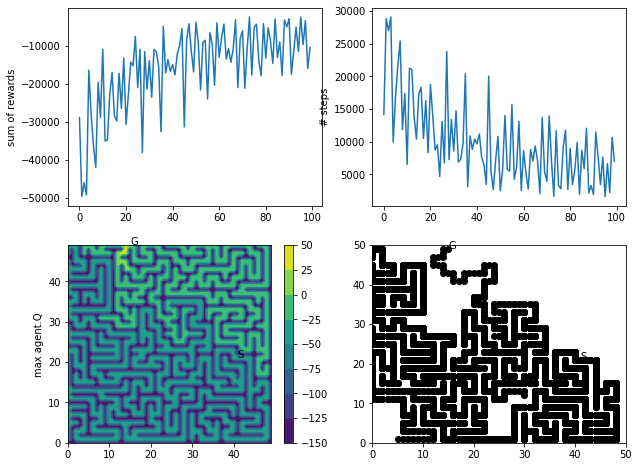

In [10]:
# Print time taken to compute path, the grid size (x and y), path taken, and the statistics of the RL agent's decision making.
print("Time taken:", endtime, "seconds")
print("GRID SIZE: ", "X: ", len(env._map), "Y: ", len(env._map[0]))
plot_train(agent, rtrace, steps, trace, start)

In [11]:
# plot_trace(agent, start, test_trace)

In [12]:
trace

array([[41, 21],
       [42, 21],
       [43, 21],
       ...,
       [14, 48],
       [14, 49],
       [15, 49]])

In [13]:
env.get_size()

array([50, 50])